# MODEL 1




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats


## Pre procc

In [ ]:
df = pd.read_csv('macro_data_cleaned.csv')
print(df.columns)


Index(['Date', 'Inflation', 'Unemployment', 'Interest_Rate', 'GDP',
       'Industrial_Output', 'Money_Supply', 'Consumer_Confidence',
       'Treasury_Yield', 'SP500_Returns'],
      dtype='object')


In [ ]:
# converting Unnamed0 to date
df = pd.read_csv('macro_data_cleaned.csv')
print(df.columns)

df = df.rename(columns={'Unnamed: 0': 'Date'})

# Convert to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

df.info()


Index(['Date', 'Inflation', 'Unemployment', 'Interest_Rate', 'GDP',
       'Industrial_Output', 'Money_Supply', 'Consumer_Confidence',
       'Treasury_Yield', 'SP500_Returns'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 801 entries, 1959-01-31 to 2025-09-30
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Inflation            801 non-null    float64
 1   Unemployment         801 non-null    float64
 2   Interest_Rate        801 non-null    float64
 3   GDP                  801 non-null    float64
 4   Industrial_Output    801 non-null    float64
 5   Money_Supply         801 non-null    float64
 6   Consumer_Confidence  801 non-null    float64
 7   Treasury_Yield       801 non-null    float64
 8   SP500_Returns        801 non-null    float64
dtypes: float64(9)
memory usage: 62.6 KB


In [ ]:
df.head()

,Inflation,Unemployment,Interest_Rate,GDP,Industrial_Output,Money_Supply,Consumer_Confidence,Treasury_Yield,SP500_Returns
Date,,,,,,,,,
1959-01-31,29.01,6.0,2.48,3352.129,21.9616,286.6,90.8,4.02,0.434707
1959-02-28,29.00,5.9,2.43,3352.129,22.3917,287.7,90.8,3.96,-0.072139
1959-03-31,28.97,5.6,2.80,3352.129,22.7142,289.2,90.8,3.99,0.054140
1959-04-30,28.98,5.2,2.96,3427.667,23.1981,290.1,90.8,4.12,3.878069
1959-05-31,29.04,5.1,2.90,3427.667,23.5476,292.2,95.3,4.31,1.892690


In [ ]:
print(df.isnull().sum())
print(df.isnull().sum().sum())

Inflation              0
Unemployment           0
Interest_Rate          0
GDP                    0
Industrial_Output      0
Money_Supply           0
Consumer_Confidence    0
Treasury_Yield         0
SP500_Returns          0
dtype: int64
0


In [ ]:
df = df.dropna()

## VAR

In [ ]:
data = df.copy()

for col in ['GDP', 'Industrial_Output', 'Money_Supply']:
    if (data[col] <= 0).any():
        data[f'logdiff_{col}'] = data[col].diff()
    else:
        data[f'logdiff_{col}'] = np.log(data[col]).diff()

data['diff_Inflation'] = data['Inflation'].diff()
data['diff_Interest_Rate'] = data['Interest_Rate'].diff()
data['diff_Treasury_Yield'] = data['Treasury_Yield'].diff()

data['Unemployment'] = data['Unemployment']
data['Consumer_Confidence'] = data['Consumer_Confidence']
data['SP500'] = data['SP500_Returns']

vars_for_var = [
    'diff_Inflation', 'Unemployment', 'diff_Interest_Rate',
    'logdiff_GDP', 'logdiff_Industrial_Output', 'logdiff_Money_Supply',
    'Consumer_Confidence', 'diff_Treasury_Yield', 'SP500'
]

Y = data[vars_for_var].dropna()
print("Final stationary dataset shape:", Y.shape)
display(Y.head())


Final stationary dataset shape: (800, 9)


,diff_Inflation,Unemployment,diff_Interest_Rate,logdiff_GDP,logdiff_Industrial_Output,logdiff_Money_Supply,Consumer_Confidence,diff_Treasury_Yield,SP500
Date,,,,,,,,,
1959-02-28,-0.01,5.9,-0.05,0.000000,0.019395,0.003831,90.8,-0.06,-0.072139
1959-03-31,-0.03,5.6,0.37,0.000000,0.014300,0.005200,90.8,0.03,0.054140
1959-04-30,0.01,5.2,0.16,0.022284,0.021080,0.003107,90.8,0.13,3.878069
1959-05-31,0.06,5.1,-0.06,0.000000,0.014954,0.007213,95.3,0.19,1.892690
1959-06-30,0.07,5.0,0.49,0.000000,0.001137,0.006481,95.3,0.03,-0.357872


In [ ]:
model = VAR(Y)
lag_results = model.select_order(maxlags=12)
print(lag_results.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -27.30      -27.25   1.393e-12      -27.28
1       -34.59     -34.06*   9.495e-16      -34.39
2       -35.02      -34.01   6.189e-16      -34.63
3       -35.22      -33.73   5.047e-16     -34.65*
4       -35.30      -33.33   4.672e-16      -34.54
5       -35.32      -32.87   4.576e-16      -34.38
6      -35.34*      -32.40  4.508e-16*      -34.21
7       -35.32      -31.90   4.605e-16      -34.01
8       -35.34      -31.44   4.530e-16      -33.84
9       -35.28      -30.91   4.800e-16      -33.60
10      -35.29      -30.43   4.776e-16      -33.42
11      -35.23      -29.90   5.050e-16      -33.18
12      -35.17      -29.36   5.391e-16      -32.94
--------------------------------------------------


In [ ]:
optimal_lag = 3
var_model = model.fit(optimal_lag)
print(var_model.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Nov, 2025
Time:                     20:01:32
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -33.6427
Nobs:                     797.000    HQIC:                  -34.5540
Log likelihood:           4070.35    FPE:                5.57848e-16
AIC:                     -35.1227    Det(Omega_mle):     4.08841e-16
--------------------------------------------------------------------
Results for equation diff_Inflation
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                                0.747517         0.164440            4.546           0.000
L1.diff_Inflation                    0.563092         0.036297           15.513        

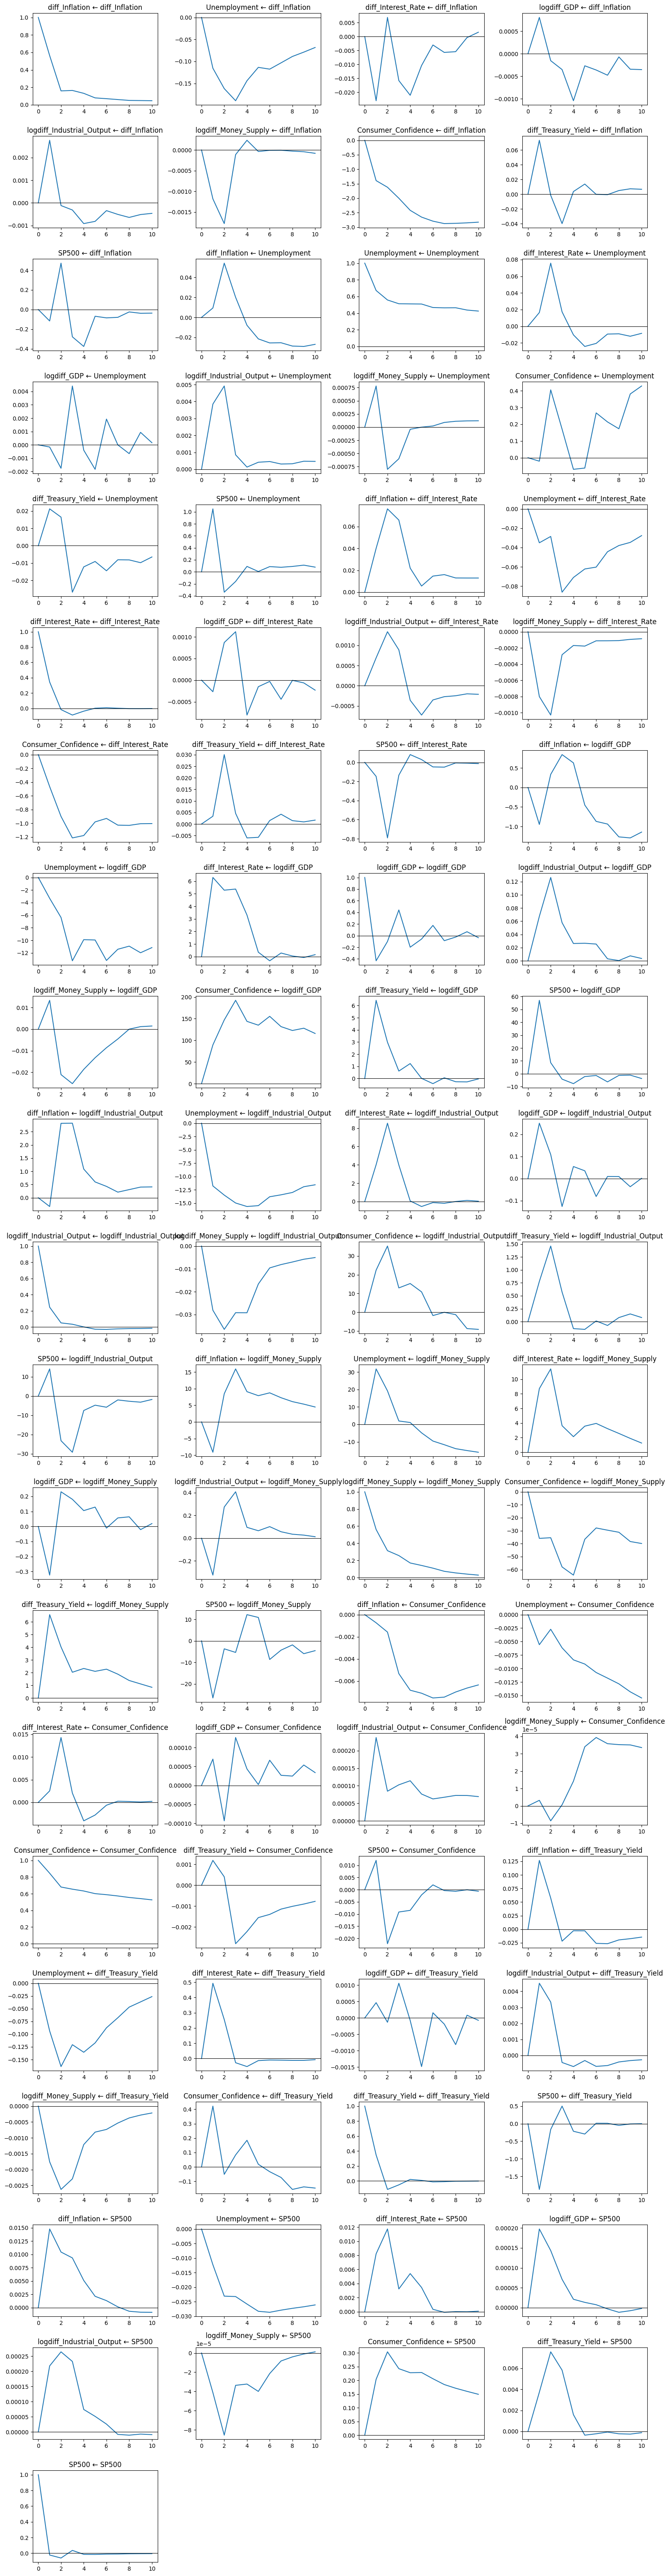

In [ ]:
irf = var_model.irf(10)
responses = var_model.names
impulses = var_model.names

ncols = 4
n_plots = len(responses) * len(impulses)
nrows = (n_plots + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 3))
axes = axes.flatten()

plot_idx = 0
for impulse in impulses:
    for response in responses:
        ax = axes[plot_idx]
        data = irf.irfs[:, responses.index(response), impulses.index(impulse)]
        ax.plot(np.arange(len(data)), data, color="C0")
        ax.axhline(0, color="black", linewidth=0.8)
        ax.set_title(f"{response} ← {impulse}")
        plot_idx += 1

for ax in axes[plot_idx:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


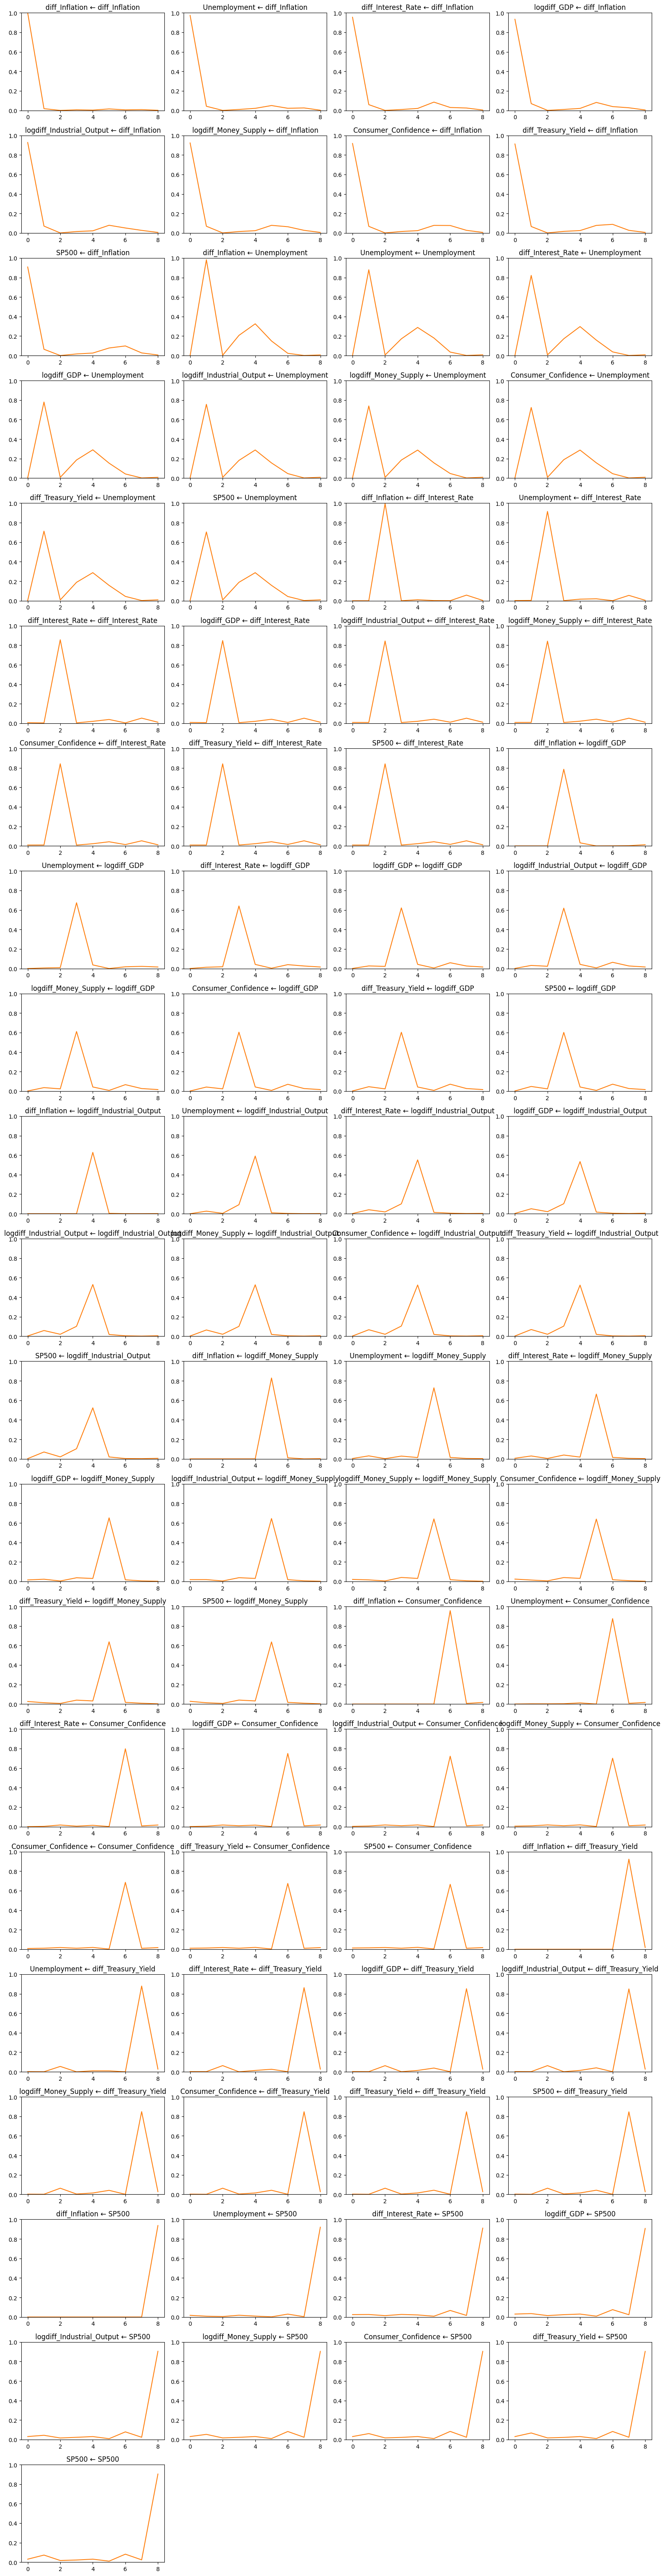

In [ ]:
fevd = var_model.fevd(10)
responses = var_model.names
impulses = var_model.names

ncols = 4
n_plots = len(responses) * len(impulses)
nrows = (n_plots + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 3))
axes = axes.flatten()

plot_idx = 0
for impulse in impulses:
    for response in responses:
        ax = axes[plot_idx]
        data = fevd.decomp[:, responses.index(response), impulses.index(impulse)]
        ax.plot(np.arange(len(data)), data, color="C1")
        ax.axhline(0, color="black", linewidth=0.8)
        ax.set_ylim(0, 1)
        ax.set_title(f"{response} ← {impulse}")
        plot_idx += 1

for ax in axes[plot_idx:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
forecast = var_model.forecast(df.values[-3:], steps=12)

forecast_df = pd.DataFrame(
    forecast,
    columns=df.columns,
    index=pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(), periods=12, freq='M')
)

forecast_df

/tmp/ipython-input-4279233670.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index=pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(), periods=12, freq='M')


,Inflation,Unemployment,Interest_Rate,GDP,Industrial_Output,Money_Supply,Consumer_Confidence,Treasury_Yield,SP500_Returns
2025-10-31,139054.472202,-3.424468e+05,382069.486449,-9280.703134,7641.559186,15873.701697,6.748481e+06,399389.172366,3.454601e+06
2025-11-30,414612.068885,-9.031427e+05,513868.279346,10384.255848,12853.867408,10116.545682,1.041030e+07,314295.130747,6.684582e+05
2025-12-31,453081.014662,-1.307615e+06,539126.126493,13784.064647,8956.435734,6798.603138,1.095516e+07,189720.700784,-3.134270e+05
2026-01-31,374295.524647,-1.402583e+06,341749.823211,-2516.695343,6027.991487,4850.972370,9.553777e+06,146351.728490,-1.339974e+05
2026-02-28,304409.255786,-1.625946e+06,177058.384986,3802.167743,5015.406072,3657.918960,9.698338e+06,90589.480048,-2.615477e+05
2026-03-31,253286.258954,-1.807242e+06,134720.274401,5172.039021,3557.544902,2771.169391,9.684677e+06,69244.839750,-4.822964e+05
2026-04-30,197720.378014,-1.824016e+06,123056.591940,-1375.735371,1755.108359,2136.576107,8.548659e+06,58685.332015,-5.089851e+05
2026-05-31,147324.560462,-1.870937e+06,92265.208754,1055.852465,1020.414309,1690.854884,7.997531e+06,36229.345429,-3.796774e+05
2026-06-30,117577.197672,-1.909070e+06,72303.548832,1534.248901,635.465268,1286.470005,7.553321e+06,31182.154905,-4.326349e+05
2026-07-31,96758.683018,-1.889535e+06,62274.882627,-859.370485,99.704403,986.516186,6.739625e+06,30481.370602,-4.555490e+05


In [ ]:
print("ADF Test Results (Before Transformation):")
adf_results = {}
for col in df.columns:
    result = adfuller(df[col].dropna())
    adf_results[col] = result[1]
    print(f"{col}: p-value = {result[1]:.4f}")

for col in df.columns:
    if (df[col] > 0).all() and adf_results[col] > 0.05:
        df[col] = np.log(df[col])
        print(f"Applied log transform to {col}")

print("\nADF Test Results (After Log Transform):")
for col in df.columns:
    result = adfuller(df[col].dropna())
    print(f"{col}: p-value = {result[1]:.4f}")

for col in df.columns:
    result = adfuller(df[col].dropna())
    if result[1] > 0.05:
        df[col] = df[col].diff().dropna()
        print(f"Differenced {col}")

df = df.dropna()
print("\nStationarity transformation complete.")


ADF Test Results (Before Transformation):
Inflation: p-value = 0.9988
Unemployment: p-value = 0.0101
Interest_Rate: p-value = 0.0418
GDP: p-value = 0.9991
Industrial_Output: p-value = 0.7370
Money_Supply: p-value = 1.0000
Consumer_Confidence: p-value = 0.0360
Treasury_Yield: p-value = 0.6490
SP500_Returns: p-value = 0.0000
Applied log transform to Inflation
Applied log transform to GDP
Applied log transform to Industrial_Output
Applied log transform to Money_Supply
Applied log transform to Treasury_Yield

ADF Test Results (After Log Transform):
Inflation: p-value = 0.5587
Unemployment: p-value = 0.0101
Interest_Rate: p-value = 0.0418
GDP: p-value = 0.1836
Industrial_Output: p-value = 0.1918
Money_Supply: p-value = 0.5225
Consumer_Confidence: p-value = 0.0360
Treasury_Yield: p-value = 0.3134
SP500_Returns: p-value = 0.0000
Differenced Inflation
Differenced GDP
Differenced Industrial_Output
Differenced Money_Supply
Differenced Treasury_Yield

Stationarity transformation complete.


In [ ]:
max_lags = 12
model = VAR(df)

for i in range(1, max_lags + 1):
    result = model.fit(i)
    print(f"Lag Order = {i}")
    print(f"AIC : {result.aic}")
    print(f"BIC : {result.bic}")
    print(f"HQIC: {result.hqic}")
    print("-"*30)


Lag Order = 1
AIC : -47.79725422302766
BIC : -47.26971669471857
HQIC: -47.59458616371581
------------------------------
Lag Order = 2
AIC : -48.2818026225255
BIC : -47.278493637357684
HQIC: -47.896331081365574
------------------------------
Lag Order = 3
AIC : -48.50557619604318
BIC : -47.02555689986359
HQIC: -47.93691879786678
------------------------------
Lag Order = 4
AIC : -48.533750901929764
BIC : -46.57607938322853
HQIC: -47.78152399602891
------------------------------
Lag Order = 5
AIC : -48.53099261888873
BIC : -46.094723895031
HQIC: -47.5948112732009
------------------------------
Lag Order = 6
AIC : -48.563647316416564
BIC : -45.64783331979524
HQIC: -47.44312531167617
------------------------------
Lag Order = 7
AIC : -48.55267332640691
BIC : -45.15636289051577
HQIC: -47.247423150262925
------------------------------
Lag Order = 8
AIC : -48.53576512209875
BIC : -44.65800396752542
HQIC: -47.04539796319827
------------------------------
Lag Order = 9
AIC : -48.56493614828775


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/tmp/ipython-input-1393963586.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')


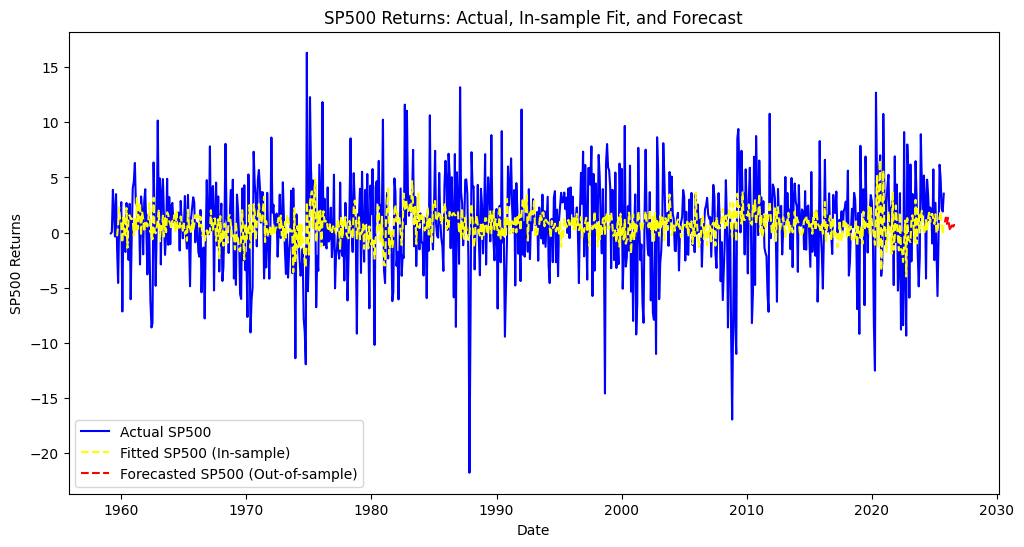

In [ ]:
var_model = VAR(df)
var_results = var_model.fit(maxlags=6)

# In-sample fitted values
in_sample_forecast = var_results.fittedvalues

# Out-of-sample forecast
forecast_array = var_results.forecast(df.values[-var_results.k_ar:], steps=12)
forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')
forecast_df = pd.DataFrame(forecast_array, index=forecast_index, columns=df.columns)

plt.figure(figsize=(12,6))
plt.plot(df['SP500_Returns'], label='Actual SP500', color='blue')
plt.plot(in_sample_forecast['SP500_Returns'], label='Fitted SP500 (In-sample)', linestyle='--', color='yellow')
plt.plot(forecast_df['SP500_Returns'], label='Forecasted SP500 (Out-of-sample)', linestyle='--', color='red')
plt.title('SP500 Returns: Actual, In-sample Fit, and Forecast')
plt.xlabel('Date')
plt.ylabel('SP500 Returns')
plt.legend()
plt.show()

In [ ]:
# Durbin-Watson test for autocorrelation
out = durbin_watson(var_results.resid)
for col, val in zip(df.columns, out):
    print(f'{col}: {val:.2f}')

# Jarque-Bera test for normality
jb_test = stats.jarque_bera(var_results.resid)
print("\nJarque-Bera Test (Normality):", jb_test)


Inflation: 2.02
Unemployment: 2.00
Interest_Rate: 2.01
GDP: 2.00
Industrial_Output: 2.02
Money_Supply: 2.02
Consumer_Confidence: 1.98
Treasury_Yield: 1.99
SP500_Returns: 2.00

Jarque-Bera Test (Normality): SignificanceResult(statistic=np.float64(81518.26999703482), pvalue=np.float64(0.0))


In [ ]:
stability = var_results.is_stable()
print("VAR model is stable:", stability)
print(var_results.roots)


VAR model is stable: True
[ 3.90854434+3.29500846j  3.90854434-3.29500846j -2.20461014+1.37859369j
 -2.20461014-1.37859369j  0.40775329+1.75008595j  0.40775329-1.75008595j
 -0.87661049+1.53683212j -0.87661049-1.53683212j  1.17040328-1.17849555j
  1.17040328+1.17849555j -1.62683632-0.24873982j -1.62683632+0.24873982j
 -0.78388259-1.36845431j -0.78388259+1.36845431j  1.4676159 -0.40688408j
  1.4676159 +0.40688408j -0.37204435-1.46474864j -0.37204435+1.46474864j
 -1.41305411-0.52987662j -1.41305411+0.52987662j  1.1789297 +0.91851352j
  1.1789297 -0.91851352j  0.95992553+1.09635967j  0.95992553-1.09635967j
 -0.91311809+1.11963975j -0.91311809-1.11963975j -1.43553329-0.j
  0.11974797+1.42960981j  0.11974797-1.42960981j  0.43249611-1.36479909j
  0.43249611+1.36479909j -1.1635183 +0.81654891j -1.1635183 -0.81654891j
  1.22317304+0.64537352j  1.22317304-0.64537352j -0.4045702 +1.31264158j
 -0.4045702 -1.31264158j -1.37148157-0.j         -0.83005749+1.07806076j
 -0.83005749-1.07806076j  0.43926

In [ ]:
print(var_results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Nov, 2025
Time:                     20:01:55
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -45.6478
Nobs:                     794.000    HQIC:                  -47.4431
Log likelihood:           9635.03    FPE:                8.12727e-22
AIC:                     -48.5636    Det(Omega_mle):     4.44795e-22
--------------------------------------------------------------------
Results for equation Inflation
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.002778         0.001059            2.622           0.009
L1.Inflation                   0.386326         0.037623           10.268           0.000
L1.Unemployment     

In [ ]:
# In-sample evaluation
rmse_in_sample = {}
mae_in_sample = {}

for col in df.columns:
    rmse_in_sample[col] = np.sqrt(mean_squared_error(df[col][var_results.k_ar:],
                                                     in_sample_forecast[col]))
    mae_in_sample[col] = mean_absolute_error(df[col][var_results.k_ar:],
                                             in_sample_forecast[col])

print("In-sample RMSE:")
for col, val in rmse_in_sample.items():
    print(f"{col}: {val:.4f}")

print("\nIn-sample MAE:")
for col, val in mae_in_sample.items():
    print(f"{col}: {val:.4f}")


In-sample RMSE:
Inflation: 0.0022
Unemployment: 0.3568
Interest_Rate: 0.4177
GDP: 0.0048
Industrial_Output: 0.0081
Money_Supply: 0.0030
Consumer_Confidence: 3.3372
Treasury_Yield: 0.0508
SP500_Returns: 4.0973

In-sample MAE:
Inflation: 0.0016
Unemployment: 0.1850
Interest_Rate: 0.2357
GDP: 0.0031
Industrial_Output: 0.0053
Money_Supply: 0.0020
Consumer_Confidence: 2.5271
Treasury_Yield: 0.0356
SP500_Returns: 3.1301
